In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


**STEP 1: IMPORT PACKAGES AND LOAD DATA**

The first step is to import the packages that will be used to manipulate and explore the data, as well as the desired machine learning model to test. 
We also need to load the training and test datasets.

In [2]:
# 1.1. Import required packages that will be used later

# Import several Python packages used for ploting figures
import seaborn as sns # to make figures
from IPython.display import display # to display multiple seaborn figures generated in the same notebook cell
import matplotlib.pyplot as plt # to make some plots and display multiple seaborn figures generated in the same notebook cell

# Import packages to model data from Scikit-Learn
from sklearn.linear_model import LogisticRegression # Logistic regression package
from sklearn.ensemble import RandomForestClassifier # Random forest classifier package
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler # to scale variables

In [3]:
# 1.2. Import the Titanic datasets
# When working with data, typically the dataset needs to be split into a training dataset to fit the model and a test dataset to validate the model.
# In this case, Kaggle has already split the data, so we will import the training and test dataset separately

trainSet = pd.read_csv('/kaggle/input/titanic/train.csv') # Import training set
testSet = pd.read_csv('/kaggle/input/titanic/test.csv') # Import test set
print('Loaded datasets') # display a message to confirm that the data has been loaded

Loaded datasets


In [4]:
# 1.3. Obtain basic information about the training data 
print(trainSet.head()) # get the names of the columns of the dataset, that will constitute the variables or features of our model, and the first 5 rows of data
print('training data shape:', trainSet.shape) # get the shape(rows,columns) of the training dataset. rows = samples, columns = variables

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
tr

**STEP 2: EXPLORE THE DATA**

Before training a Machine Learning model, it is useful to explore the data, visualizing the different variables against the output. This will help us understand which variables are more important, in other words, are better predictors of the output. This information might be used later to improve our model. 

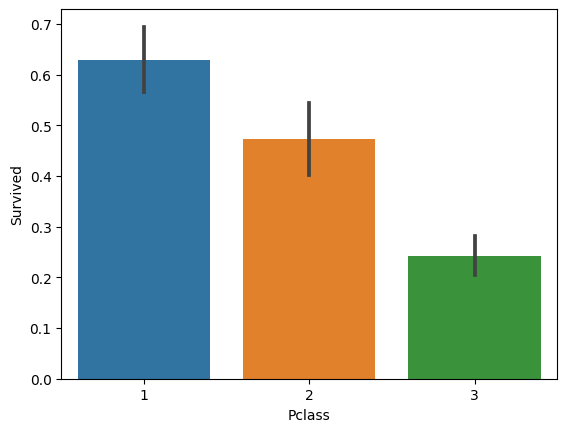

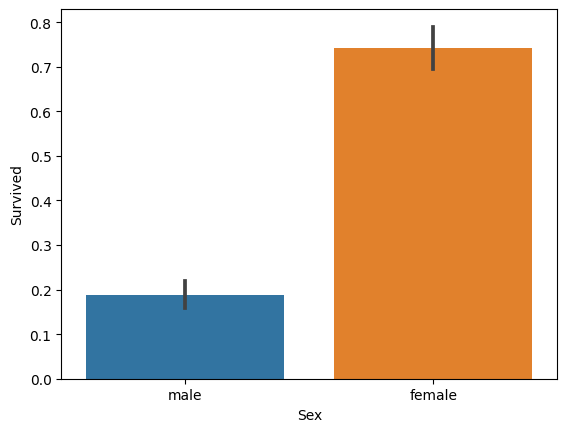

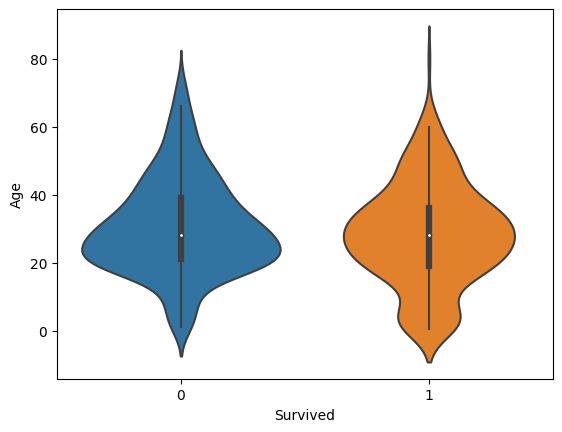

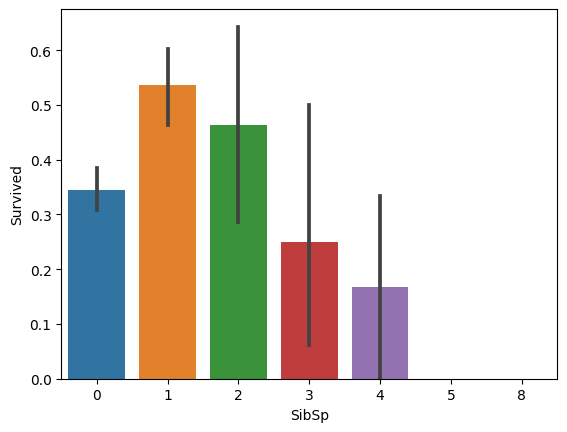

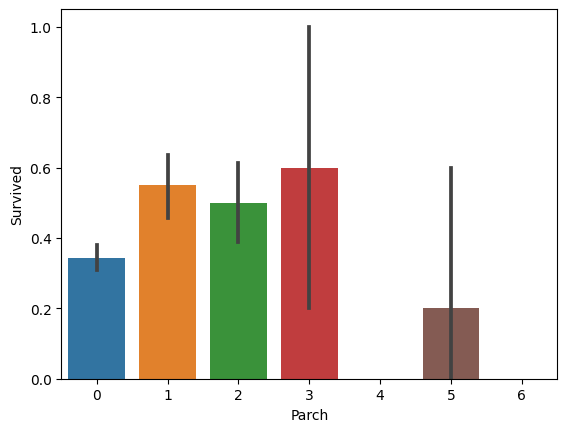

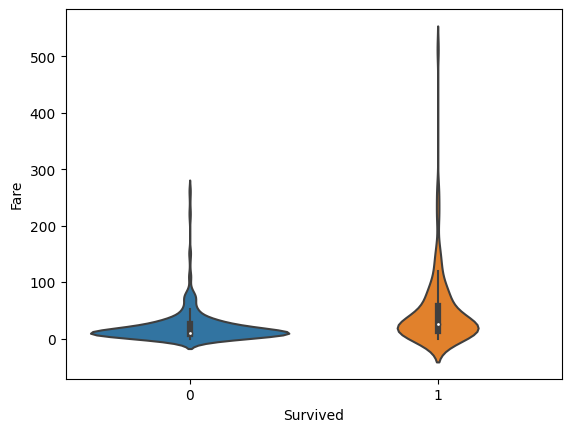

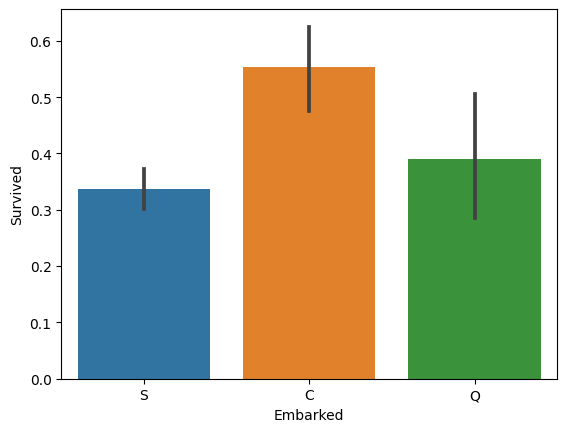

In [5]:
# 2. Let's explore the data to get an idea of the relevance of each variable: plots of each variable(or features) against output (= survival)
# ignore full name, ticket number and cabin number for now

sns.barplot(trainSet, x = 'Pclass', y = 'Survived')
plt.show()
sns.barplot(trainSet, x = 'Sex', y = 'Survived')
plt.show()
sns.violinplot(trainSet, x = 'Survived', y = 'Age')
plt.show()
sns.barplot(trainSet, x = 'SibSp', y = 'Survived')
plt.show()
sns.barplot(trainSet, x = 'Parch', y = 'Survived')
plt.show()
sns.violinplot(trainSet, x = 'Survived', y = 'Fare')
plt.show()
sns.barplot(trainSet, x = 'Embarked', y = 'Survived')
plt.show()

These plots suggest that women and passengers in the first class (higher socioeconomic status) were more likely to survive (0 = did not survive, 1 = survived). 

**STEP 3: DATA ENGINEERING**

There might be some variables that contain missing values (NaN) in some entries. If that is the case, since ML models do not accept missing values we either have to drop those samples, which will reduce the amount of data available for training and increase noise, or we can replace those missing values by an estimate of the most likely value based on other variables. 

In addition, as displayed in Step 1, some variables in the dataset are categorical. However, logistic regression only accepts numerical variables. Thus, we need to convert all categorical variables in the dataset into numerical ones. 

We need to do the same modifications in both the training and test datasets. 

In [6]:
# 3.1. Let's see if there is any column in the dataframe with NaN values

for column in trainSet: # Iterate over each column in the dataset
    if trainSet[column].isnull().any(): # check if the column contains any missing values
        print('column with nans: ',column) # if the column contains missing values, print the column name

column with nans:  Age
column with nans:  Cabin
column with nans:  Embarked


According to the output from the above cell, the variables Age, Cabin and Embarked contain NaNs. We are going to use the Age and Embarked variable for our model, but we are not going to use the Cabin number. Thus, we only need to replace the missing values in the Age and Embarked columns. 

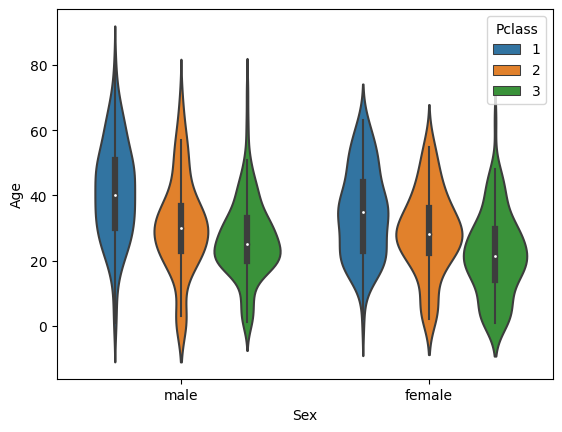

In [7]:
# 3.2.1. We could just replace the missing values by the median age of all passengers. However, just in case, let's investigate 
# if there are differences in passenger's age depending on gender and socioeconomic status 

sns.violinplot(trainSet, x = 'Sex', y = 'Age', hue='Pclass')
plt.show()

As shown in this plot, males tended to be older than females. In addition, people from class 1 tended to be older than passengers in classes 2 and 3. Thus, we should replace the missing values in the 'Age' variable by the median of the passenger's sex & class group.

In [8]:
# 3.2.2. Replace missing values in Age column with the median of the passengers sex and class group

trainSet['Age'] = trainSet['Age'].fillna(trainSet.groupby(['Pclass', 'Sex'])['Age'].transform('median'))

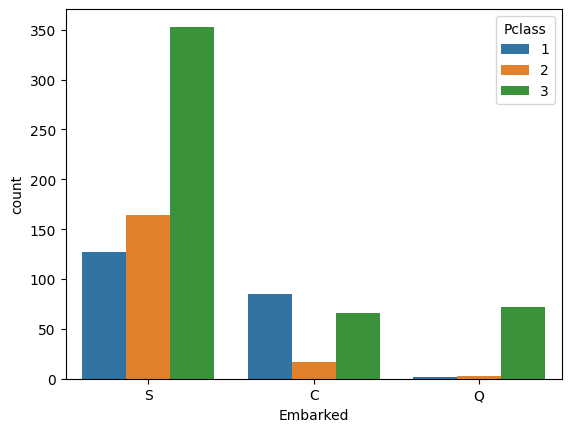

In [9]:
# 3.3.1. Some values in the Embarkment variable are missing too, let's check if the Embarkment site varied depending on 
# socioeconomic status (for instance richer passengers might leave in areas different to working class passengers)

sns.countplot(trainSet, x = 'Embarked', hue='Pclass')
plt.show()

For all passenger classes, the most common embarkment site is 'S'.

In [10]:
# 3.3.2. We'll replace the Embarked missing values by the most common embarkment site of each passenger class

trainSet['Embarked'] = trainSet['Embarked'].fillna(trainSet['Embarked'].mode().iloc[0]) 

In [11]:
# 3.4. Let's see if there is any column in the dataframe with NaN values

for column in testSet: # Iterate over each column in the dataset
    if testSet[column].isnull().any(): # check if the column contains any missing values
        print('column with nans: ',column) # if the column contains missing values, print the column name

column with nans:  Age
column with nans:  Fare
column with nans:  Cabin


In the test dataset, Age, Fare and Cabin variables contains missing values. 

In [12]:
# 3.5.1. Replace missing values in Age column with the median of the passengers sex and class group

testSet['Age'] = testSet['Age'].fillna(testSet.groupby(['Pclass', 'Sex'])['Age'].transform('median'))

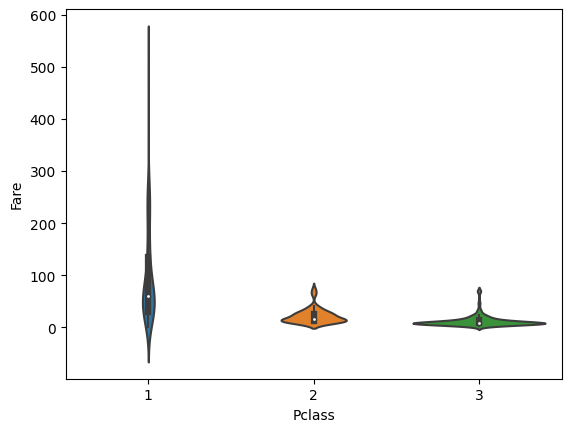

In [13]:
# 3.5.2. The fare variable probably depends on the Class, since presumably Class 1 tickets were more expensive than Class 2 and 3. 
# Let's plot Fare agains Class to confirm this

sns.violinplot(testSet, y = 'Fare', x = 'Pclass')
plt.show()

It looks like passengers in Class 1 paid much more than passengers in Class 2 and 3. 

In [14]:
# 3.5.3. Let's replace the missing values in the Fare variable by the median fare of each passenger's Class group

testSet['Fare'] = testSet['Fare'].fillna(testSet.groupby(['Pclass'])['Fare'].transform('median'))

In [15]:
# 3.6. Since some of the variables are categorical, but we want to trian a logistic regression model, which needs numerical input,
# let's transform all categorical variables (Sex and Embarked) into numerical ones in both the train and test datasets

trainSet['Sex'] = trainSet['Sex'].replace(['male', 'female'],[0, 1])
trainSet['Embarked'] = trainSet['Embarked'].replace(['S', 'C', 'Q'],[0, 1, 2])

testSet['Sex'] = testSet['Sex'].replace(['male', 'female'],[0, 1])
testSet['Embarked'] = testSet['Embarked'].replace(['S', 'C', 'Q'],[0, 1, 2])

/tmp/ipykernel_64/2066842492.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  trainSet['Sex'] = trainSet['Sex'].replace(['male', 'female'],[0, 1])
/tmp/ipykernel_64/2066842492.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  trainSet['Embarked'] = trainSet['Embarked'].replace(['S', 'C', 'Q'],[0, 1, 2])
/tmp/ipykernel_64/2066842492.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-

**STEP 4: TRAIN THE LOGISTIC REGRESSION MODEL**

We'll train the model only using the following variables: 
* Pclass
* Sex
* Age 
* Fare, 
* Embarked, 
* SibSp (if they traveled with a sibling or spouse) 
* Parch (if they traveled with a child or parent)

In [16]:
# 4.1. First let's see how a simple logistic regression model does. Let's use all the variables plotted for now. 
# Let's fit the model
model = LogisticRegression(max_iter = 200)
model.fit(trainSet.loc[:,['Pclass','Sex', 'Age','Fare','Embarked', 'SibSp', 'Parch']], trainSet['Survived'])

# then let's get the model's accuracy
predY = model.predict(testSet.loc[:,['Pclass','Sex', 'Age','Fare','Embarked', 'SibSp', 'Parch']])

# save prediction
outcome = pd.DataFrame({'PassengerId': testSet['PassengerId'].values,'Survived': predY})
outcome.to_csv('outcome.csv', index=False)  
print(outcome)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


This approach resulted in a prediction accuracy of **0.76076**

To improve the performance of the model, and help reach convergence faster, in less than 100 iterations, let's scale the data. 

In [17]:
# 4.2.1. We could use the minmaxscaler function, which sets the minimum to 0 and the maximum to 1. However, as we saw that we have some outliers, 
# for instance in the Fare variable, we will use the standard scaler which sets mean to 0 and std to 1. 

std_scaler = StandardScaler() # initialize standard scaler
 
df_scaled = std_scaler.fit_transform(trainSet.loc[:,['Pclass','Sex', 'Age','Fare','Embarked', 'SibSp', 'Parch']].to_numpy())
trainScaled = pd.DataFrame(df_scaled, columns=['Pclass','Sex', 'Age','Fare','Embarked', 'SibSp', 'Parch'])# scale training dataset

df_scaled = std_scaler.fit_transform(testSet.loc[:,['Pclass','Sex', 'Age','Fare','Embarked', 'SibSp', 'Parch']].to_numpy())
testScaled = pd.DataFrame(df_scaled, columns=['Pclass','Sex', 'Age','Fare','Embarked', 'SibSp', 'Parch'])# scale test dataset


In [18]:
# 4.2.2. Let's train the model and test its accuracy with the scaled variables

model = LogisticRegression(max_iter = 100) # initialize model
model.fit(trainScaled, trainSet['Survived']) # train model
predY = model.predict(testScaled) # make prediction

# save prediction
outcome = pd.DataFrame({'PassengerId': testSet['PassengerId'].values,'Survived': predY})
outcome.to_csv('outcome2.csv', index=False)  
print(outcome)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


Scaling the data resulted in slight accuracy increase to: **0.76555**

In [19]:
# 4.3. Finally, it's time for some HYPERPARAMETER OPTIMIZATION. Let's find the hyperparameters of the model that result in best
# model performance. In other words, the ones that have the best bias-variance tradeoff.

# Initialize model
model = LogisticRegression()

# Define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Set hyperparameters grid
param_grid = {
    'penalty': ['l1', 'l2'],      # Regularization term
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga']      # Optimization algorithm
}

# Define search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=1) 

# Train model and iterate over hyperparameters
grid_search.fit(trainScaled, trainSet['Survived'])

# Extract the best model and its parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)

Fitting 15 folds for each of 24 candidates, totalling 360 fits
Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}


Best hyperparameters were: C = 10, penalty = L1, solver = saga

In [20]:
# Use the best model to predict
predY = best_model.predict(testScaled)

# Save prediction
outcome = pd.DataFrame({'PassengerId': testSet['PassengerId'].values,'Survived': predY})
outcome.to_csv('outcome3.csv', index=False)  

After **hyperparameter optimization**, the accuracy increased to **0.77511**